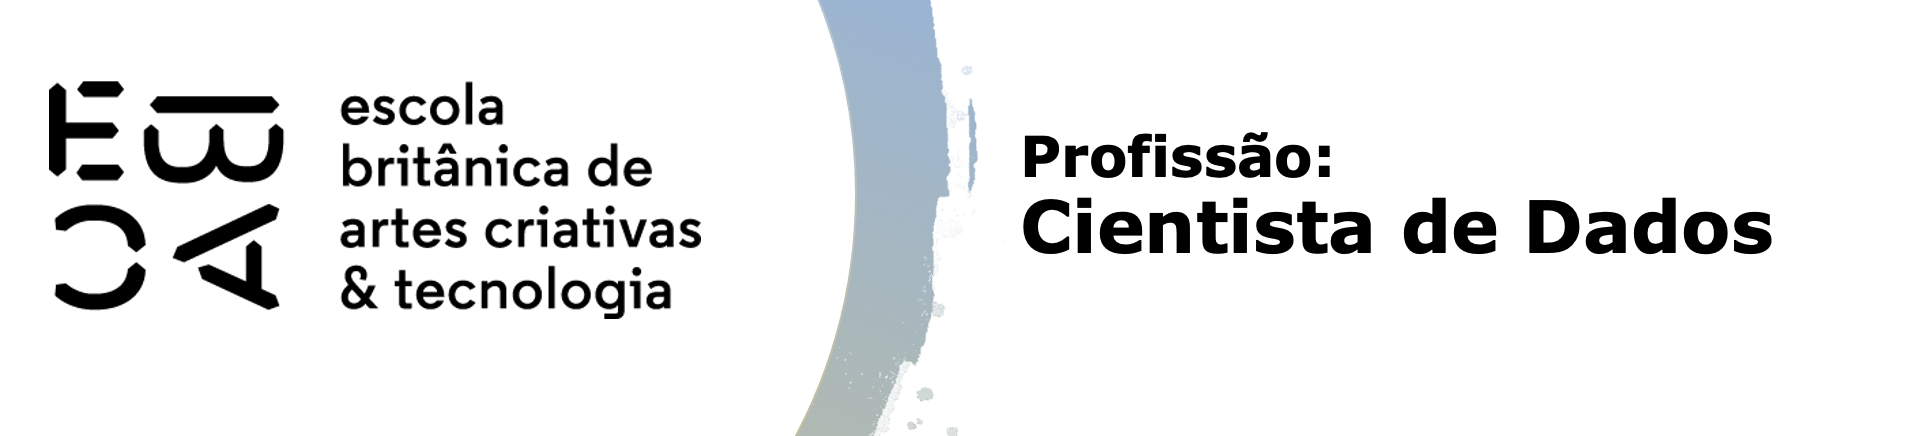

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [95]:
X_train = pd.read_csv('dataset_X_train.csv').set_index(['index', 'subject'])[['tGravityAcc-min()-X', 'fBodyAccJerk-entropy()-X', 'tGravityAcc-max()-Y']]
y_train = pd.read_csv('dataset_y_train.csv')
X_test = pd.read_csv('dataset_X_test.csv').set_index(['index', 'subject'])[['tGravityAcc-min()-X', 'fBodyAccJerk-entropy()-X', 'tGravityAcc-max()-Y']]
y_test = pd.read_csv('dataset_y_test.csv')

### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

In [96]:
clf = DecisionTreeClassifier(random_state=999, max_depth=20)
caminho = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

In [97]:
ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])
ccp_alphas = np.sort(ccp_alphas)[::5]
ccp_alphas.shape

(59,)

### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [98]:
%%time
clf = DecisionTreeClassifier(random_state=999, max_depth=20)
grid_parametros = {'ccp_alpha': ccp_alphas}
grid = GridSearchCV(estimator=clf, param_grid=grid_parametros, cv=10, verbose=100)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 59 candidates, totalling 590 fits
[CV 1/10; 1/59] START ccp_alpha=0.0.............................................
[CV 1/10; 1/59] END ..............ccp_alpha=0.0;, score=0.796 total time=   0.0s
[CV 2/10; 1/59] START ccp_alpha=0.0.............................................
[CV 2/10; 1/59] END ..............ccp_alpha=0.0;, score=0.740 total time=   0.0s
[CV 3/10; 1/59] START ccp_alpha=0.0.............................................
[CV 3/10; 1/59] END ..............ccp_alpha=0.0;, score=0.811 total time=   0.0s
[CV 4/10; 1/59] START ccp_alpha=0.0.............................................
[CV 4/10; 1/59] END ..............ccp_alpha=0.0;, score=0.687 total time=   0.0s
[CV 5/10; 1/59] START ccp_alpha=0.0.............................................
[CV 5/10; 1/59] END ..............ccp_alpha=0.0;, score=0.754 total time=   0.0s
[CV 6/10; 1/59] START ccp_alpha=0.0.............................................
[CV 6/10; 1/59] END ..............ccp_alpha=0.

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(max_depth=20, random_state=999),
             param_grid={'ccp_alpha': array([0.00000000e+00, 1.13347842e-04, 1.20560886e-04, 1.23652191e-04,
       1.26949583e-04, 1.28665118e-04, 1.31159646e-04, 1.32529784e-04,
       1.34154158e-04, 1.35136200e-04, 1.45085238e-04, 1.61969105e-04,
       1.68604915e-04, 1.77868921e-04, 1.86429457e-04, 1.90424374e...
       3.62713094e-04, 3.88783098e-04, 4.01774504e-04, 4.18186861e-04,
       4.46391347e-04, 4.83617459e-04, 5.16924661e-04, 5.32856736e-04,
       5.47592467e-04, 5.81451072e-04, 6.45884733e-04, 6.96310920e-04,
       7.44977300e-04, 8.50430788e-04, 9.58785212e-04, 1.01238486e-03,
       1.22348442e-03, 1.58027268e-03, 1.80834420e-03, 2.51558763e-03,
       4.87976229e-03, 8.18026586e-03, 1.67148656e-01])},
             verbose=100)

In [99]:
resultados = pd.DataFrame(grid.cv_results_)

In [100]:
melhor_ccp = resultados.iloc[grid.best_index_,4]
melhor_ccp

np.float64(0.008180265864245174)

In [101]:
print(grid.best_score_)
print(grid.best_params_)

0.7718916370896185
{'ccp_alpha': np.float64(0.008180265864245174)}


### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

In [102]:
clf = DecisionTreeClassifier(random_state=999, ccp_alpha=melhor_ccp).fit(X_train, y_train)

In [103]:
clf.score(X_test, y_test)

0.7207329487614523

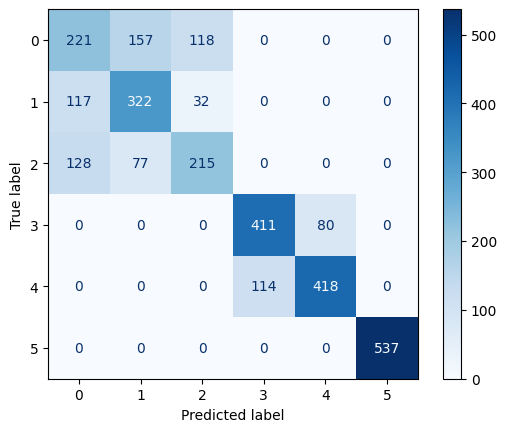

In [104]:
y_pred = clf.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

A True Label com mais erros foi "0", ou seja, movimento 1, nesse caso, vamos criar uma binária apenas para ela

In [105]:
X_train = pd.read_csv('dataset_X_train.csv').set_index(['index', 'subject'])
y_train = pd.read_csv('dataset_y_train.csv')
X_test = pd.read_csv('dataset_X_test.csv').set_index(['index', 'subject'])
y_test = pd.read_csv('dataset_y_test.csv')
y_train.loc[y_train['0'] != 1, '0'] = 0
y_test.loc[y_test['0'] != 1, '0'] = 0

In [106]:
clf = DecisionTreeClassifier(random_state=999, min_samples_leaf=20, max_depth=4).fit(X_train, y_train)

In [107]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': clf.feature_importances_
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
best_features = feature_importance.iloc[:3]['Feature']
feature_importance.head(3)

,Feature,Importance
503,fBodyAccMag-std(),0.352379
166,tBodyGyroJerk-mad()-X,0.352154
65,"tGravityAcc-arCoeff()-X,1",0.113027


In [108]:
X_train = pd.read_csv('dataset_X_train.csv').set_index(['index', 'subject'])[['tGravityAcc-min()-X', 'fBodyAccJerk-entropy()-X', 'tGravityAcc-max()-Y', 'fBodyAccMag-std()', 'tBodyGyroJerk-mad()-X', 'tGravityAcc-arCoeff()-X,1']]
y_train = pd.read_csv('dataset_y_train.csv')
X_test = pd.read_csv('dataset_X_test.csv').set_index(['index', 'subject'])[['tGravityAcc-min()-X', 'fBodyAccJerk-entropy()-X', 'tGravityAcc-max()-Y', 'fBodyAccMag-std()', 'tBodyGyroJerk-mad()-X', 'tGravityAcc-arCoeff()-X,1']]
y_test = pd.read_csv('dataset_y_test.csv')

In [109]:
clf = DecisionTreeClassifier(random_state=999, max_depth=20)
caminho = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

In [110]:
ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])
ccp_alphas = np.sort(ccp_alphas)[::5]
ccp_alphas.shape

(35,)

In [111]:
%%time
clf = DecisionTreeClassifier(random_state=999, max_depth=20)
grid_parametros = {'ccp_alpha': ccp_alphas}
grid = GridSearchCV(estimator=clf, param_grid=grid_parametros, cv=10, verbose=100)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 35 candidates, totalling 350 fits
[CV 1/10; 1/35] START ccp_alpha=0.0.............................................
[CV 1/10; 1/35] END ..............ccp_alpha=0.0;, score=0.837 total time=   0.0s
[CV 2/10; 1/35] START ccp_alpha=0.0.............................................
[CV 2/10; 1/35] END ..............ccp_alpha=0.0;, score=0.772 total time=   0.0s
[CV 3/10; 1/35] START ccp_alpha=0.0.............................................
[CV 3/10; 1/35] END ..............ccp_alpha=0.0;, score=0.833 total time=   0.0s
[CV 4/10; 1/35] START ccp_alpha=0.0.............................................
[CV 4/10; 1/35] END ..............ccp_alpha=0.0;, score=0.797 total time=   0.0s
[CV 5/10; 1/35] START ccp_alpha=0.0.............................................
[CV 5/10; 1/35] END ..............ccp_alpha=0.0;, score=0.861 total time=   0.0s
[CV 6/10; 1/35] START ccp_alpha=0.0.............................................
[CV 6/10; 1/35] END ..............ccp_alpha=0.

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(max_depth=20, random_state=999),
             param_grid={'ccp_alpha': array([0.00000000e+00, 1.26949583e-04, 1.29216540e-04, 1.32239149e-04,
       1.34088085e-04, 1.35728011e-04, 1.63220892e-04, 2.14221827e-04,
       2.25969428e-04, 2.33820405e-04, 2.41808729e-04, 2.50182173e-04,
       2.58930704e-04, 2.66406514e-04, 2.73138341e-04, 2.85773953e-04,
       3.26441785e-04, 3.88621172e-04, 4.37154354e-04, 4.47674694e-04,
       4.66345406e-04, 4.81731543e-04, 5.06419898e-04, 6.12078346e-04,
       6.72086027e-04, 7.39065223e-04, 8.09370266e-04, 9.14864909e-04,
       1.06875805e-03, 1.19148926e-03, 1.76449238e-03, 2.09134989e-03,
       6.52540250e-03, 1.54421757e-02, 1.86138242e-01])},
             verbose=100)

In [112]:
resultados = pd.DataFrame(grid.cv_results_)

In [113]:
melhor_ccp = resultados.iloc[grid.best_index_,4]
melhor_ccp

np.float64(0.0009148649090674175)

In [114]:
clf = DecisionTreeClassifier(random_state=999, ccp_alpha=melhor_ccp).fit(X_train, y_train)

In [115]:
clf.score(X_test, y_test)

0.838479809976247

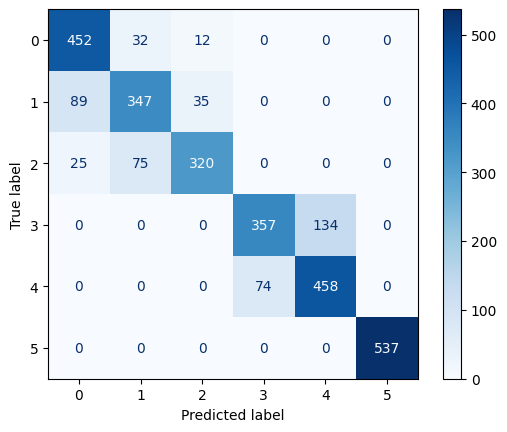

In [116]:
y_pred = clf.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')

Tivemos uma melhora significativa na acurácia do modelo, diminuindo bastante os falsos positivos na True Label 0, porém com um pouco de aumento na 3, agora, poderíamos fazer a mesma coisa com os demais!